In [1]:
%matplotlib inline
import requests as http
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from lib.lastfm import Lastfm
from lib.spotify import User
import time
import calendar
import datetime
import re
import unicodedata

pd.options.display.max_rows = 20
api_key = 'b333a19b2c0397e8e4c1224b49b3e7cd'
api_base = 'http://ws.audioscrobbler.com/2.0/?format=json&'
user_name = 'carolinebills'
data = http.get(api_base + 'method=user.getrecenttracks&limit=200&api_key='\
                + api_key + '&user=' + user_name).json()

In [2]:
token = 'BQB6jXl4TDbnYNsZ1X7PnbZ1rhafSm7pjVo2Q786a2hJc3u0o8i1T6jSndc4iu2uJ2LNWeb8oKRsdSA8s-V0-f-I0auW4x3DFAw3LVI_sXOzqacLDcPzhEGG1jWe90Gw5NGDfpEMtByQSgoNiYN3vwV7q88bvGdg8zPOko0QLzR4zWgxThcw1PkcN8pPLRI'
received_features = ['danceability', 'energy', 'acousticness', 'valence', 'tempo']
user = User(received_features, 40, token=token)
lastfm = Lastfm()

In [3]:
track_data = data['recenttracks']['track']
limit = data['recenttracks']['@attr']['totalPages']
page = 1
history = []
# for nested dictionary entry requests
class FakeNone:
    def get(*args):
        return FakeNone()
# ensures that there's no key error exception
def check_track(track):
    arr = [track.get('name', FakeNone()),
     track.get('artist', FakeNone()).get('#text', FakeNone()),
      track.get('date', FakeNone()).get('uts', FakeNone())
    ]
    return [None if type(x) == FakeNone else x for x in arr]

for track in track_data:
    history.append(check_track(track))
    
print('Starting! There are ' + limit + ' pages')
while int(data['recenttracks']['@attr']['page']) is not int(limit):
    if page % 25 is 0:
        print('Page %i' % page)
    page += 1
    data = http.get(api_base + 'method=user.getrecenttracks&limit=200&api_key=' + api_key + \
                    '&user=' + user_name + '&page=' + str(page)).json()
    for track in data['recenttracks']['track']:
        history.append(check_track(track))



Starting! There are 7 pages


## Goals:
- most listened to songs / artists (as well as during a time)
- songs/artists you've neglected
- genres (tags)

In [4]:
history_df = pd.DataFrame(history)
history_df.columns = ['track_name', 'artists', 'date']
history_df

,track_name,artists,date
0,Your Time (feat. KIELY),Savoy,1488647156
1,Drifting,G-Eazy,1488646852
2,Minor Thing,Red Hot Chili Peppers,1488646019
3,Get on Top,Red Hot Chili Peppers,1488645821
4,Sleepyhead,Passion Pit,1488645646
5,Death Was Arrested,North Point InsideOut,1488645332
6,Sons And Daughters - Live,North Point InsideOut,1488644911
7,Americano,Lady Gaga,1488644125
8,Ways To Go,Grouplove,1488643909
9,The Recipe,Kendrick Lamar,1488643555


In [6]:
# determine the n-most frequently played songs from a given pandas series
def determine_frequencies(data, num_songs, neglected=False):
    if neglected:
        counter = Counter(data)
        frequencies = counter.most_common()
        index = len(frequencies) - num_songs
        return frequencies[ index :]
    else:
        counter = Counter(data)
        return counter.most_common(num_songs)

# clean lastfm data to only have songs currently in spotify library
def refine_df(original_df, feature_name, must_haves):
    def check(val):
        for must_have in must_haves:
            if must_have.lower() == val.lower():
                return True
            
        return False
    arr_check = np.vectorize(check)
    return original_df[ arr_check(original_df[ feature_name ]) ]

def set_count(spotify):
    count_arr = [None] * len(spotify)
    for row in spotify.itertuples():
        count = occurences_in_history(row.track_name, row.artists)
        count_arr[row.Index] = count
    spotify['count'] = pd.Series(count_arr)
    
history_songs = history_df['track_name'].values
history_artists = history_df['artists'].values

def occurences_in_history(track_name, track_artist):
    count = 0
    track_artists = track_artist.split(',')
    for track, history_artist in zip(history_songs, history_artists):
        # ignore potential formatting differences
        if track.lower() == track_name.lower():
            for artist in track_artists:
                if strip_accents(artist.lower()) == strip_accents(history_artist.lower()):
                    count += 1
    return count


def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)
        
songs = user.library['track_name']
history_df = refine_df(history_df, 'track_name', songs)
set_count(user.library)

In [7]:
user.library

,track_name,track_id,artists,popularity,count,genres,danceability,energy,acousticness,valence,tempo
0,The Only Thing,6Rt6KwuF7I8ZkdZG2G0bYr,Sufjan Stevens,64,0,"indie,folk",0.519,0.145,0.987000,0.4880,158.975
1,Animal,6vSq5q5DCs1IvwKIq53hj2,Miike Snow,57,0,"electronic,electropop",0.774,0.734,0.015500,0.6340,118.021
2,American Teen,312WNtMs3F28cUukaPY9bo,Khalid,15,0,"electronic,pop",0.658,0.623,0.068300,0.2090,100.436
3,8TEEN,5bgwqaRSS3M8WHWruHgSL5,Khalid,13,0,"electronic,pop",0.830,0.585,0.225000,0.6390,105.030
4,Winter,4V3VshJLUTCIWa77YiAkvM,Khalid,11,0,"electronic,pop",0.678,0.575,0.101000,0.3790,100.007
5,Our Great God,5nlWhhr6c9Vci4CzdVn6iT,North Point InsideOut Featuring Heath Balltzglier,18,0,,0.356,0.891,0.000111,0.1880,158.046
6,Death Was Arrested,7eBybNhcjCylloMZT2QjQE,"North Point InsideOut,Seth Condrey",47,2,",,softrock,espaol",0.306,0.742,0.029800,0.1490,155.873
7,Death Was Arrested,1qYHmEjR1WcEG50T1HMlqH,"North Point InsideOut,Seth Condrey",52,2,",,softrock,espaol",0.409,0.755,0.226000,0.1960,149.851
8,My Life - Live,5OHARjeDwp8WCtSqFqAxB3,"North Point InsideOut,Steve Fee",27,0,",,worship,christian",0.596,0.949,0.006230,0.4630,109.969
9,Close - Live,2hMZ9u13WWKAWMcygARQHw,"North Point InsideOut,Lauren Daigle",33,0,",,contemporarychristian,praise",0.362,0.815,0.076100,0.2370,169.751


In [8]:
class TimeMachine:
    
    def __init__(self, year):
        self.seasons = {
            'spring': ( time.strptime('21 Mar ' + year, '%d %b %Y'),
                      time.strptime('21 Jun ' + year, '%d %b %Y')),
            'summer': ( time.strptime('21 Jun ' + year, '%d %b %Y'),
                      time.strptime('23 Sep ' + year, '%d %b %Y')),
            'fall': ( time.strptime('23 Sep ' + year, '%d %b %Y'),
                      time.strptime('21 Dec ' + year, '%d %b %Y')),
            'winter': ( time.strptime('21 Dec ' + year, '%d %b %Y'),
                        time.strptime('21 Mar ' + str(int(year) + 1), '%d %b %Y'))
        }
        self.year = year
        
    def set_year(self, new_year):
        self = self.__init__(new_year)
        
    def in_season(self, season, df):
        timeslice = self.seasons[season]
        def check_time(seconds):
            try:
                listen_time =  time.gmtime(int(seconds))
            except TypeError:
                return False
            return listen_time > timeslice[0] and listen_time < timeslice[1]
        arr_time_check = np.vectorize(check_time)
        return df[arr_time_check(df['date'])]
    
    def in_year(self, df):
        date = datetime.date(int(self.year), 1, 1)
        def check_time(seconds):
            try: 
                listen_time =  datetime.date.fromtimestamp(int(seconds))
            except TypeError:
                return False
            return listen_time.year == date.year
        arr_time_check = np.vectorize(check_time)
        return df[ arr_time_check(df['date'])]
    


In [9]:
# make a timemachine to 2014, check out top artists from then
obj = TimeMachine('2014')
year_df = obj.in_year(history_df)
determine_frequencies(year_df['artists'], 20)
year_df

,track_name,artists,date


In [10]:
user.library.head()

,track_name,track_id,artists,popularity,count,genres,danceability,energy,acousticness,valence,tempo
0,The Only Thing,6Rt6KwuF7I8ZkdZG2G0bYr,Sufjan Stevens,64,0,"indie,folk",0.519,0.145,0.9870,0.488,158.975
1,Animal,6vSq5q5DCs1IvwKIq53hj2,Miike Snow,57,0,"electronic,electropop",0.774,0.734,0.0155,0.634,118.021
2,American Teen,312WNtMs3F28cUukaPY9bo,Khalid,15,0,"electronic,pop",0.658,0.623,0.0683,0.209,100.436
3,8TEEN,5bgwqaRSS3M8WHWruHgSL5,Khalid,13,0,"electronic,pop",0.830,0.585,0.2250,0.639,105.030
4,Winter,4V3VshJLUTCIWa77YiAkvM,Khalid,11,0,"electronic,pop",0.678,0.575,0.1010,0.379,100.007


In [11]:
common_genres = [
    'hiphop',
    'rap',
    'pop',
    'rock',
    'rnb',
    'dubstep',
    'trance',
    'house',
    'trap',
    'country',
    'alternative',
    'indie',
    'reggae'
]

library_genres = user.library['genres']
def count_appearances(match_genre):
    count = 0
    for track_genre in library_genres:
        track_genre = track_genre.split(',')
        for genre in track_genre:
            if genre == match_genre:
                count += 1
    return count

count = [count_appearances(genre) for genre in common_genres]
top_genres = []
for common_genre, genre_count in zip(common_genres, count):
    top_genres.append([common_genre, genre_count])
top_genres

[['hiphop', 351],
 ['rap', 278],
 ['pop', 117],
 ['rock', 156],
 ['rnb', 64],
 ['dubstep', 31],
 ['trance', 3],
 ['house', 12],
 ['trap', 13],
 ['country', 4],
 ['alternative', 49],
 ['indie', 161],
 ['reggae', 22]]

In [12]:
def filter_for_genre(genre, df):
    truth_arr = [False] * len(df)
    for index, genres in enumerate(df['genres']):
        genres = genres.split(',')
        if genre in genres:
            truth_arr[index] = True
    return df[truth_arr]

filter_for_genre('rap', user.library)

,track_name,track_id,artists,popularity,count,genres,danceability,energy,acousticness,valence,tempo
16,Bad Things - With Camila Cabello,56cswAa9WdFBsjsTyPBAKA,"Machine Gun Kelly,Camila Cabello",83,4,"hiphop,rap,femalevocalists,pop",0.674,0.694,0.22300,0.2550,137.839
21,Money Showers,5kj1BImL0hJ719KUc2CnAg,"Fat Joe,Remy Ma,Ty Dolla $ign",67,6,"rap,hiphop,rap,hiphop,hiphop,rap",0.586,0.832,0.00606,0.5610,153.270
30,T-Shirt,7KOlJ92bu51cltsD9KU5I7,Migos,82,4,"hiphop,rap",0.865,0.687,0.24200,0.5150,139.023
34,Talk That Talk,7drd8T07dm62NkcYESlVhu,"Rihanna,JAY Z",48,1,"pop,rnb,hiphop,rap",0.700,0.686,0.04040,0.4640,84.003
39,Up Down (Do This All Day),1uH1Nd8vet2uoZSDFSDwbh,"T-Pain,B.o.B",59,4,"rnb,hiphop,hiphop,rap",0.763,0.530,0.27200,0.4540,97.033
69,Telephone Calls,7LlRdlop7Cy8tvJv1cQ82w,"A$AP Mob,A$AP Rocky,Tyler, The Creator,Playboi...",43,7,"hiphop,rap,hiphop,rap,rap,trap,hiphop,hiphop",0.460,0.767,0.21400,0.4530,82.363
71,Don't Like.1,12D0n7hKpPcjuUpcbAKjjr,"Kanye West,Chief Keef,Pusha T,Big Sean,Jadakiss",60,0,"hiphop,rap,hiphop,rap,hiphop,rap,hiphop,rap,hi...",0.668,0.628,0.00822,0.6200,131.880
72,Driving Ms Daisy,6IlQTriFgUeEbVx3Y10sia,"Logic,Childish Gambino",54,14,"hiphop,rap,hiphop,rap",0.660,0.823,0.33400,0.5380,159.999
73,Law,7mhk9WyqZZzvTTCQKfh2iV,"Yo Gotti,E-40",61,9,"rap,dirtysouth,rap,hiphop",0.882,0.699,0.01960,0.4250,145.008
74,POWER,2gZUPNdnz5Y45eiGxpHGSc,Kanye West,71,2,"hiphop,rap",0.538,0.912,0.01780,0.5800,154.042


In [13]:
determine_frequencies(history_df['track_name'].values, 10, neglected=True)

[("2012 (It Ain't The End)", 1),
 ('Take It Easy', 1),
 ('SHABBA', 1),
 ("Moar Ghosts 'n' Stuff", 1),
 ('Baby Grand', 1),
 ('Walcott', 1),
 ("We Didn't Start the Fire", 1),
 ('September', 1),
 ('Invention In C minor', 1),
 ('Disarm', 1)]

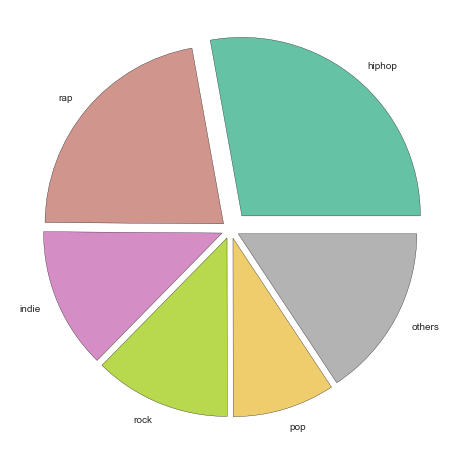

In [14]:
sorted_top_genres = sorted(top_genres, key=lambda x: x[1], reverse=True)
top_four = sorted_top_genres[:5]
others = 0
for genre in sorted_top_genres[5:]:
    others += genre[1]
labels = [elem[0] for elem in top_four]
labels.append('others')
values = [elem[1] for elem in top_four]
values.append(others)
explode = [0.1, 0.05, 0.05, 0.05, 0.05, 0.05]
plt.figure(figsize=(8,8))
plt.pie(values, labels=labels, colors=plt.cm.Set2(np.arange(0, 6)/5), explode=explode)
plt.show()

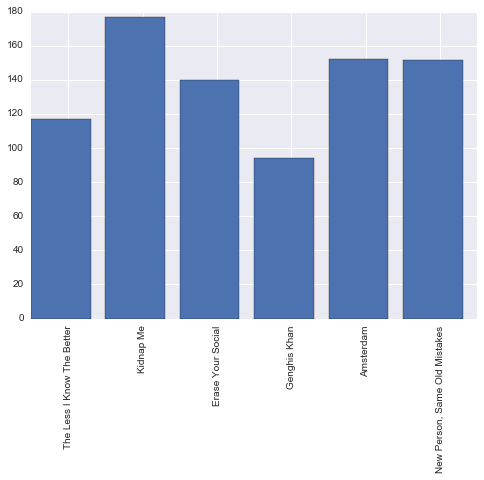

In [15]:
sorted_values = user.library.sort_values('count', ascending=False).values
top_five_values = sorted_values[:6, -1]
top_five_names = sorted_values[:6, 0]
xaxis = np.arange(0, 6)
plt.bar(xaxis, top_five_values)
plt.xticks(xaxis + 0.5, top_five_names, rotation=90)
plt.show()

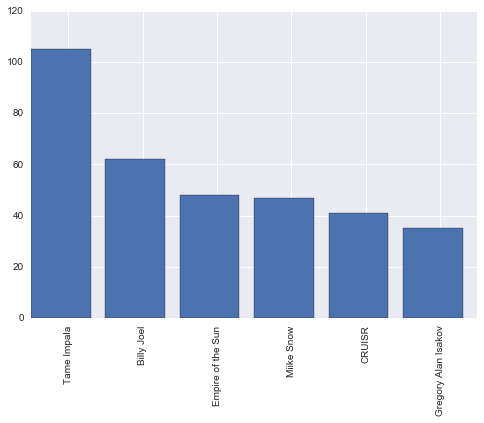

In [16]:
def count_artist(artist_name, df):
    def has_artist(artists):
        list_artists = artists.split(',')
        for artist in list_artists:
            if artist.lower() == artist_name.lower():
                return True
        return False
    has_artist = np.vectorize(has_artist)
    artist_df = df[ has_artist(df['artists'])]
    counts = artist_df['count']
    return counts.sum()
    
count_artist('Eminem', user.library)
artist_play_counts = [count_artist(name, user.library) for name in user.artists]
artists_df = pd.DataFrame( {
        'artist_name': user.artists,
        'play_count': artist_play_counts
    })
sorted_play_counts = artists_df.sort_values('play_count', ascending=False).values
top_five_artist_names = sorted_play_counts[:6, 0]
top_five_artist_plays = sorted_play_counts[:6, 1]
xaxis = np.arange(0, 6)
plt.bar(xaxis, top_five_artist_plays)
plt.xticks(xaxis + 0.5, top_five_artist_names, rotation=90)
plt.show()

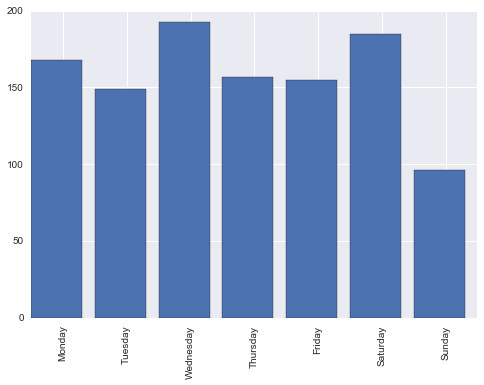

In [17]:
times = history_df['date'].values
def get_wkday(seconds):
    gmtime = time.gmtime(int(seconds))
    return gmtime.tm_wday
get_wkday = np.vectorize(get_wkday)
wkday_counts = Counter(get_wkday(times)).most_common()
wkday_counts.sort(key=lambda x: x[0])
days, counts = zip(*wkday_counts)
days = np.array(days)
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.bar(days, counts)
plt.xticks(days + 0.5, weekdays, rotation=90)
plt.show()

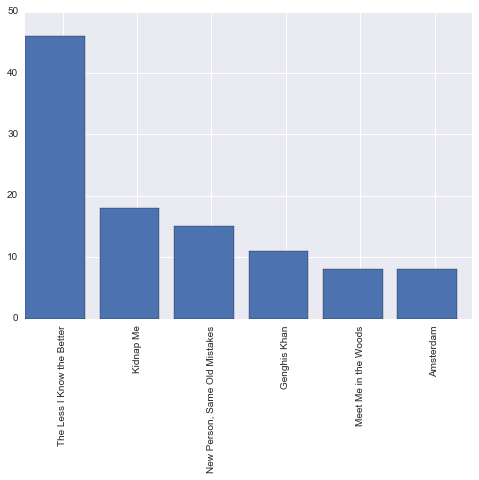

In [18]:
track_history = history_df['track_name'].values
def count_repeats(track_name, index):
    count = 0
    while index < len(track_history) - 1 and track_history[index + 1] == track_name:
        count += 1
        index += 1
    return count
repeated_songs = {}
for index, track in enumerate(track_history):
    repeats = count_repeats(track, index)
    if track in repeated_songs:
        if repeats > repeated_songs[track]:
            repeated_songs[track] = repeats
    elif repeats > 0:
        repeated_songs[track] = repeats
        
repeated_song_titles = list(repeated_songs.keys())
repeated_song_counts = [repeated_songs[track] for track in repeated_song_titles]
repeated_df = pd.DataFrame({
        'track_names': repeated_song_titles,
        'count': repeated_song_counts
    })
sorted_values = repeated_df.sort_values('count', ascending=False).values
values = sorted_values[:6, 0]
names = sorted_values[:6, 1]
xaxis = np.arange(0, 6)
plt.bar(xaxis, values)
plt.xticks(xaxis + 0.5, names, rotation=90)
plt.show()

In [19]:
history_df

,track_name,artists,date
0,Your Time (feat. KIELY),Savoy,1488647156
1,Drifting,G-Eazy,1488646852
2,Minor Thing,Red Hot Chili Peppers,1488646019
3,Get on Top,Red Hot Chili Peppers,1488645821
4,Sleepyhead,Passion Pit,1488645646
5,Death Was Arrested,North Point InsideOut,1488645332
6,Sons And Daughters - Live,North Point InsideOut,1488644911
7,Americano,Lady Gaga,1488644125
8,Ways To Go,Grouplove,1488643909
9,The Recipe,Kendrick Lamar,1488643555


## References
Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011)

John D. Hunter, "Matplotlib: A 2D Graphics Environment", Computin

Raschka, Sebastian, and Randal S. Olson. Python Machine Learning: Unlock Deeper Insights into Machine    Learning with This Vital Guide to Cutting-edge Predictive Analytics. Birmingham: Packt, 2015. Print.g in Science & Engineering, vol.9, no. 3, pp. 90-95, May/June 2007, doi:10.1109/MCSE.2007.55  

In [ ]:
plt.cm.Accent(np.arange(0, 6))

In [ ]:
import importlib
import lib.curator as curator

In [ ]:
importlib.reload(curator)
curator.tag_filter(user.library, 'rap')

In [ ]:
token = 'BQDCyccLfzo1ZcWMwP2BmrldK1VPt3g53D4NYOcKq9z4qTvT4YKe8pTf1EAxI3CvJC4spizgzeCiLq6cowW3jOB0gz9QBLAI0AmF9BWvnPJpE-f8kN2bM-tefL-O3aJPl-PmBayEV7PHCpMZLAUIVymqk6uNcmWrhWOXaZxsZaKTRZarIzFOvUfmE9MbExHxN96aOaDqjTFa'
test_user = User(received_features, 40, token=token)